# Classificação multinomial

### Índice <a name="topo"></a>
- 1. [Introdução](#1)
    - 1.1 [Carregar a base do exemplo](#1.1)
    - 1.2 [Dados faltantes](#1.2)
    - 1.3 [Descritiva inicial](#1.3)
- 2. [Preenchimento de dados faltantes](#2)
    - 2.1 [2.1 Análise descritiva: vale a pena preencher ```sex``` com modelo?](#2.1)
    - 2.2 [2.2 Modelo de preenchimento](#2.2)
- 3. [Classificação multinomial](#3)
    - 3.1 [A árvore](#3.1)
    - 3.2 [Pós-poda](#3.2)
    - 3.3 [A árvore](#3.3)
    - 3.4 [Avaliação do resultado](#3.4)

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### 1. Introdução <a name="1"></a>
[Voltar para o índice](#topo)

#### 1.1 Carregando a base de exemplo<a name="1.1"></a>
[Voltar para o índice](#topo)

Nesta aula vamos trabalhar com a base *penguins*. Essa base pode ser carregada com a ajuda do pacote ```seaborn``` conforme abaixo. Já trabalhamos algumas vezes com ela, ela traz dados biométricos de três raças de pinguins. A nossa tarefa vai ser escrever um algoritmo que classifique o pinguim em uma dessas espécies com base nas características biométricas dele.

In [43]:
pg = sns.load_dataset('penguins')
pg.shape

(344, 7)

In [44]:
pg

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


#### 1.2 Dados faltantes<a name="1.2"></a>
[Voltar para o índice](#topo)  

Vamos trabalhar com o *scikitlearn*, o que significa que não podemos ter dados *missing* nem em formato *não numérico* na base. Conforme a análise abaixo, podemos ver que há dois valores missing em quatro variáveis, e a variável ```sex``` possui 11 valores não preenchidos.

In [45]:
pg.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

#### 1.3 Descritiva inicial<a name="1.3"></a>
[Voltar para o índice](#topo)  

Vamos fazer uma matriz de dispersão (*scatterplot matrix*) para visualizar quão promissora é a classificação das raças de pinguim de acordo com as variáveis biométricas.

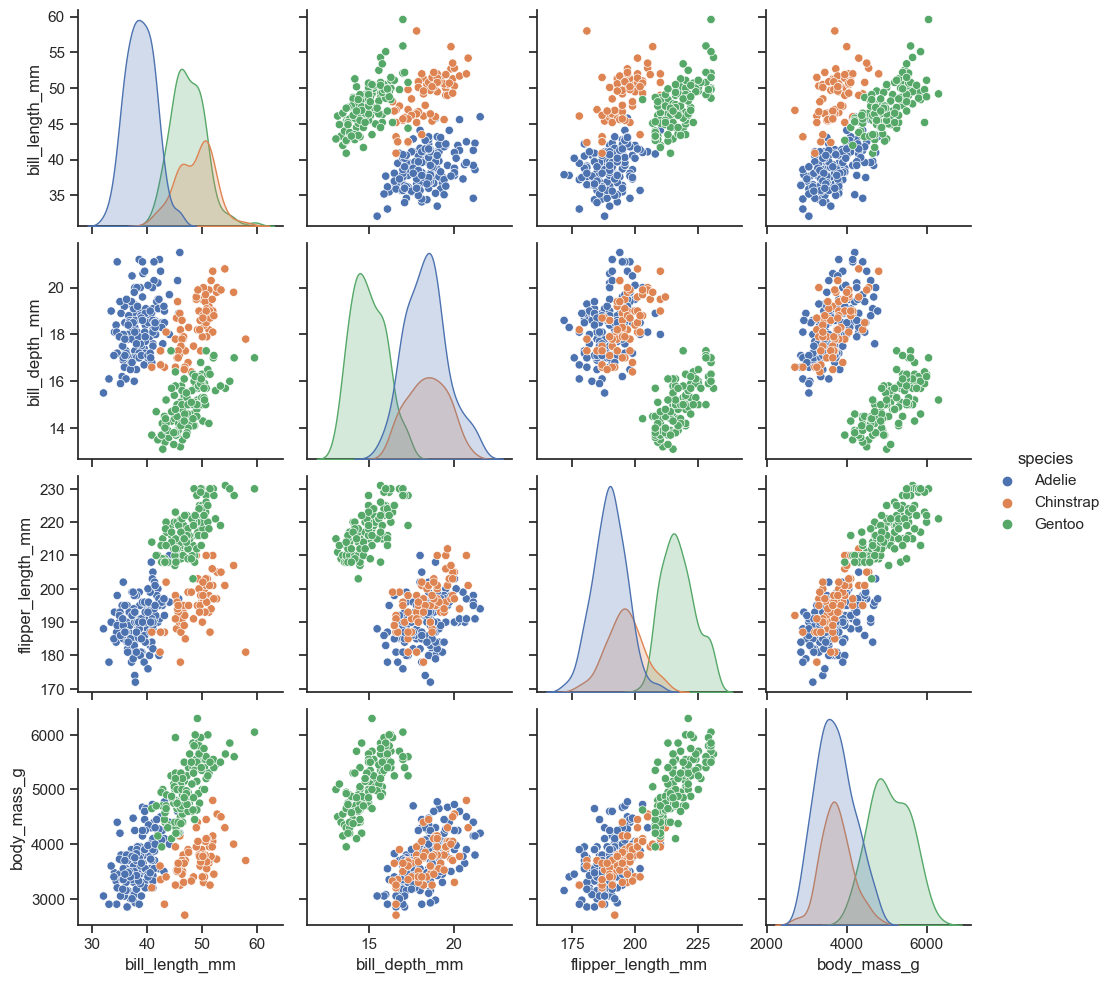

In [46]:
sns.pairplot(pg, hue='species');

Vamos nos certificar de que essas duas observações são o mesmo registro. Se for o caso, vai ter baixo impacto no nosso algoritmo elimina-los.

In [7]:
pg[pg['bill_depth_mm'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


Sim, são as mesmas, então eliminar estas observações implica em perder apenas duas observações (e bem incompletas por sinal).

In [8]:
pg1 = pg[~pg['bill_depth_mm'].isna()].copy()

### 2 Preenchimento de dados faltantes<a name="2"></a>
[Voltar para o índice](#topo)  

Para a variável ```sex```, temos mais 9 registros com dados faltantes. Claro que em se tratando de análise de dados, podemos ter inúmeras alternativas, mas eu vejo aqui três razoáveis com prós e contras:

- Eliminar a variável ```sex```. Essa alternativa pode significar abrir mão de uma fonte de varição importante que deve ajdar a classificar os indivíduos em suas respectivas classes.
- Eliminar os 9 registros faltantes: parece uma solução ok, mas já vamos para 11 registros eliminados de 344.
- Fazer imputação de dados: Isso significa tentar "adivinhar" qual o valor para a variável faltante para não perder o registro. Se fizermos isso mal, podemos introduzir ruído na base, por outro lado, recuperamos esses registros.

A terceira opção parece mais interessante. Agora... que método podemos utilizar? 
- Podemos fazer imputação pela moda - utilizar o valor que mais aparece na base.
- Imputação aleatória: simplemente sortear um valor conforme a distribuição observada
- Ou ainda, a solução que vamos adotar, fazer uma "imputação por árvore":
    - Vamos construir uma árvore de decisão para classificar o sexo dos pinguins dadas as demais variáveis
    - Em seguida vamos usar esta árvore para classificar os valores faltantes.

Se a nossa árvore for boa, vamos cometer um erro pequeno, e em todo caso, vamos "salvar" as observações com dados faltantes. Como contra, eu apontaria o trabalho de se construir esta árvore. No caso, como tudo é um aprendizado, vamos arregaçar as mangas :)

#### 2.1 Análise descritiva: vale a pena preencher ```sex``` com modelo?<a name="2.1"></a>
[Voltar para o índice](#topo)  

Em primeiro lugar, precisamos tentar entender se "vale a pena" fazer essa árvore. Intuitivamente, entendemos que os pinguins devem ter características bem diferentes no macho e na fêmea, a começar do peso. Vamos ver se os dados indicam isto:

<AxesSubplot: xlabel='species', ylabel='bill_length_mm'>

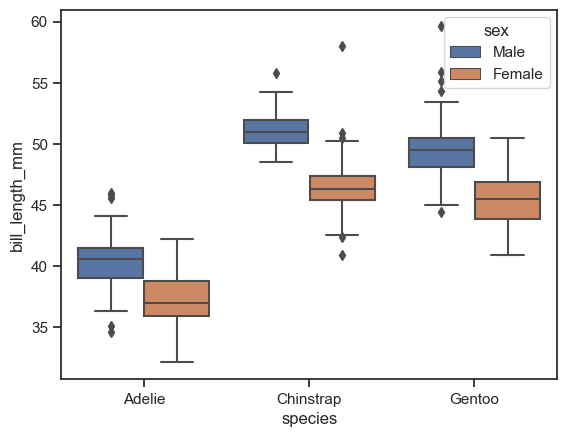

In [9]:
sns.set_theme(style="ticks")

sns.boxplot(data=pg, x='species', hue="sex", y='bill_length_mm')

Pelo visto sim, machos e fêmeas possuem medidas bem diferentes dada a espécie, principalmente.

#### 2.2 Modelo de preenchimento<a name="2.2"></a>
[Voltar para o índice](#topo)  

Vamos então para o modelo de imputação de dados. O primeiro passo é **preparar a base para classificar sexo**. Não vamos perder o objetivo de vista: agora queremos fazer um modelo para prever sexo, para imputar os valores faltantes. Vamos lá:

- Vamos retirar a variável ```sex``` da base
- Utilizar o ```get_dummies()``` para criar as variáveis dummy de ```species``` e ```island```
- Dividir a base em treino e teste
- Fazer a pós poda pelo ccp-alpha
- Classificar a base original para não perder as 9 observações

Sim, dá um trabalhinho, mas com o tempo isso tudo vai ficando mais automático ;)

Pois é, o nosso objetivo principal aqui é **aprender**. Caso contrário, seria absolutamente legítimo você decidir não fazer isto porque acha que não vale o custo vs benefício - aliás, esse é um julgamento muito útil para o cientista de dados ;)


##### Eliminando *missings* para a construção do modelo

In [10]:
pg2 = pg1[~pg1['sex'].isna()]
pg2.shape

(333, 7)

In [11]:
pg2.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

##### Criando *dummies* e separando bases de treino e teste

In [12]:
y0 = pg2.sex
X0 = pd.get_dummies(pg2.drop(columns = ['sex']), drop_first=True)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0)
X0.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,0,0,0,1
1,39.5,17.4,186.0,3800.0,0,0,0,1
2,40.3,18.0,195.0,3250.0,0,0,0,1
4,36.7,19.3,193.0,3450.0,0,0,0,1
5,39.3,20.6,190.0,3650.0,0,0,0,1


##### Construindo a árvore para classificar ```sex```
A célula abaixo monta a árvore, treina "deixando ela ser feliz" (sem limite de profundidade, número de observações ou complexidade). Também salva os *ccp alpahs* para fazermos a pós poda.

In [13]:
clf0 = DecisionTreeClassifier(random_state=42)
path = clf0.cost_complexity_pruning_path(X0_train, y0_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

##### Realiza a pós poda
Sobre a árvore acima, que é super complexa, vamos obter árvores derivadas e menos complexas seguindo o caminho indicado pelo custo de complexidade (o *ccp alpha*). Para cada árvore derivada, vamos avaliar a métrica de desempenho (no caso, a acurácia), e escolher a melhor árvore para fazer a imputação. 

In [14]:
clfs0 = []
for ccp_alpha in ccp_alphas:
    clf0 = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X0_train, y0_train)
    clfs0.append(clf0)

Vamos montar abaixo um gráfico que já vimos na aula de árvores binárias: para cada poda indicada pelo *ccp*, colocamos a métrica de desempenho da árvore na base de desenvolvimento e na base de testes.

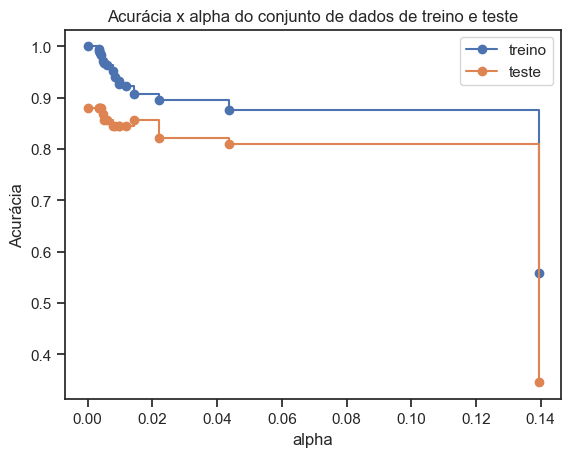

In [15]:
train_scores = [clf0.score(X0_train, y0_train) for clf0 in clfs0]
test_scores  = [clf0.score(X0_test, y0_test)   for clf0 in clfs0]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

Pronto. Abaixo tem uma "firula": Eu quero a melhor árvore, sim, mas se houverem empates, a que tenha a menor complexidade. Isso significa que eu quero pegar a maior métrica de desempenho no objeto ```test_scores```, mas se houver empates, queremos a primeira ocorrência desse máximo **da direita para a esquerda**.

Esse é um ótimo quebra cabeças de Python :) Abaixo temos um código bem pythonico que resolve isso.

In [17]:
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs0[ind_melhor_arvore]
melhor_arvore

DecisionTreeClassifier(ccp_alpha=0.003970939939533417, random_state=2360873)

##### Substituindo os missings

Agora que fizemos a árvore para a variável ```sex```, vamos utilizar esta regra para substituir os valores missing na base original. Aí você pode me perguntar: "Por quê não fazemos para as outras 4 variávels?" E eu respondo com outra pergunta: "Séro? Você acha mesmo que vale a pena por 2 observações e sem ter muito com o que prever? Boa sorte então, pode fazer!" Repito: sempre vale refletir se vale o esforço de se construir um modelo.

In [18]:
# Seleciona as variáveis a serem substituídas
prever = pd.get_dummies(pg1.drop(columns = ['sex']), drop_first=True)
prever_sex = prever[pg1['sex'].isna()]

#faz a classificação conforme a árvore
inputação_sex = melhor_arvore.predict(prever_sex)
inputação_sex

array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Male'], dtype=object)

In [19]:
# Faz a substituição propriamente dita
pg1.loc[pg1['sex'].isna(), 'sex'] = inputação_sex

print(pg1.shape)
pg1.isna().sum()

(342, 7)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Vamos salvar esta base de dados tratada, para uso futuro.

In [21]:
pg1.to_csv('data/pg1.csv', index=False)

### 3. Classificação multinomial<a name="3"></a>
[Voltar para o índice](#topo)  

Pronto, agora sim vamos para o tema principal: construir um algoritmo que classifique a **espécie** do pinguim em uma das três que aparecem na base de dados. A mecânica aqui é MUITO parecida com a classificação binária, basta utilizarmos generalizações das funções de impureza que comportem mais de duas classes e pronto: podemos usar o mesmo algoritmo.

Vamos seguir aqui passos bem parecidos:
- Tratar *missings* (acabamos de fazer isso)
- Criar *dummies*
- Construir a árvore (e deixa-la "ser feliz")
- Realizar a pós-poda e obter a árvore "ótima"

In [26]:
pg1.shape

(342, 7)

In [27]:
X = pd.get_dummies(pg1.drop(columns = ['species', 'island']), drop_first=True)
y = pg1['species']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
y_train.value_counts()

Adelie       115
Gentoo        92
Chinstrap     49
Name: species, dtype: int64

#### 3.1 A árvore<a name="3.1"></a>
[Voltar para o índice](#topo)

A árvore é bem semelhante à que já conhecemos, mas com mais de uma alternativa de resposta.

In [29]:
clf = DecisionTreeClassifier(random_state=2360873, max_depth=3).fit(X_train, y_train)

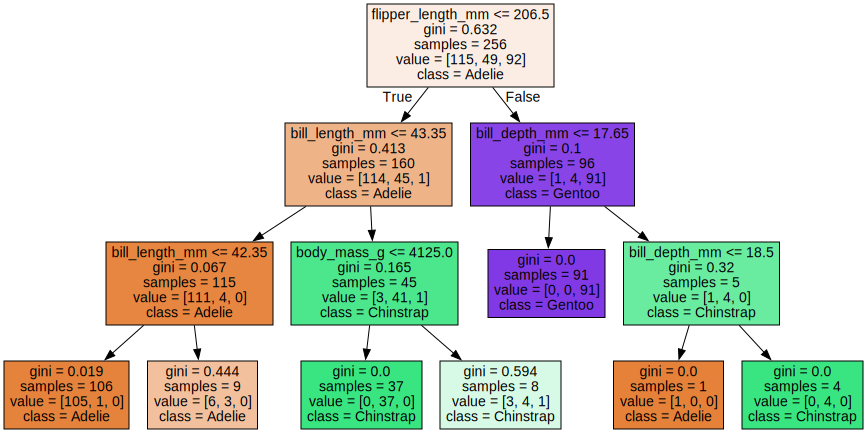

In [31]:
import graphviz
from sklearn.tree import export_graphviz
# DOT data
dot_data = export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['Adelie', 'Chinstrap', 'Gentoo'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

# Decision Tree Classifier from scikit-learn sklearn visualized with graphviz in Python

Avaliando a árvore completa

#### 3.2 Pós-poda<a name="3.2"></a>
[Voltar para o índice](#topo)  

Essa etapa é bem parecida com o que já fizemos. Vamos observar os "caminhos de poda" da árvore "grande", avaliar uma métrica de qualidade do modelo na base de testes, e selecionar a melhor.

In [32]:
caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, path.impurities

In [33]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

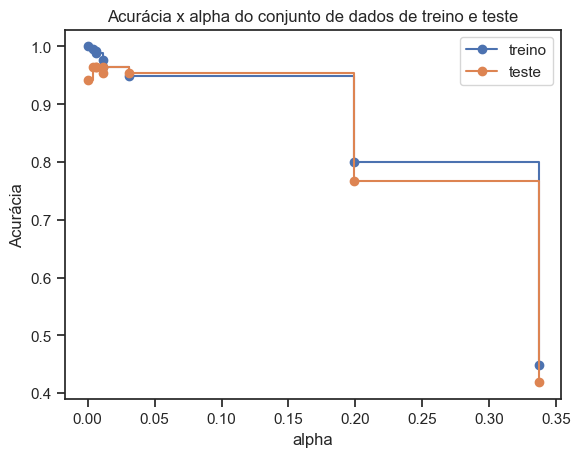

In [34]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

#### 3.3 Selecionando a melhor árvore<a name="3.3"></a>
[Voltar para o índice](#topo)  

Vamos pegar a melhor árvore utilizando a mesma lógica da árvore que usamos para preencher os registros faltantes na variável ```sex```.

In [35]:
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]
melhor_arvore

DecisionTreeClassifier(ccp_alpha=0.011566840277777775, random_state=2360873)

#### 3.4 Avaliando o resultado<a name="3.3"></a>
[Voltar para o índice](#topo)  

Agora vamos avaliar o resultado da nossa classificação utilizanod a acrurácia, na base de testes. Para um visual um pouco melhor, vamos utilizar a matriz de confusão.

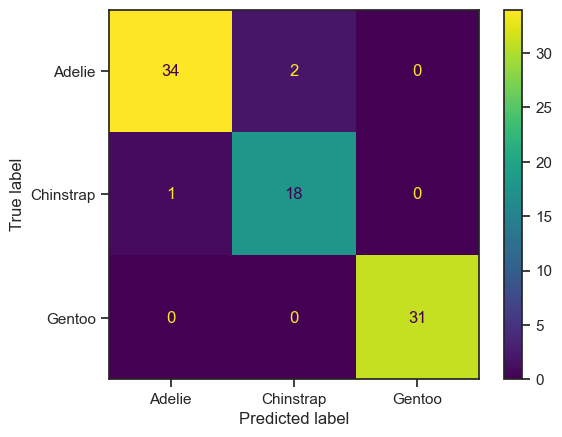

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, melhor_arvore.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=melhor_arvore.classes_).plot()

Sensacional esse resultado não? A taxa de acertos é impressionante! Até era de se esperar algo bom pela análise descritiva.

Mas, para refletir, o gancho para a próxima aula:

Será que "demos sorte" de a base de testes ter esse desempenho?  
Com outra base teriamos o mesmo desempenho?  
Como podemos obter uma métrica mais "confiável" do desempenho desse algoritmo?

# *Cross validation* I: Treinamento, Validação e Teste

### Índice <a name="topo"></a>
- 1. [Introdução](#1)
- 2. [Carregando a base](#2)
- 3. [Base de Treinamento, Validação e Teste](#3)
- 4. [Cálculo dos CCP-alphas](#4)
- 5. [Obtendo a melhor árvore](#5)
- 6. [Avaliando a melhor árvore](#6)
- 7. [Gancho para a próxima aula](#7)


### 1. Introdução <a name="1"></a>
[Voltar para o índice](#topo)

O gancho da aula passada:

- Será que "demos sorte" de a base de testes ter esse desempenho?  
- Com outra base teriamos o mesmo desempenho?  
- Como podemos obter uma métrica mais "confiável" do desempenho desse algoritmo?

Na aula passada, como a base de testes foi utilizada para 'tunar' o modelo, é razoável imaginarmos que ao aplicar o modelo a uma base mais ampla, não vamos obter exatamente esta acurácia.

Vamos fazer uma primeira tentativa de resolver este problema separando uma base de testes *holdout*, que não será utilizada nem no desenvolvimento do modelo, nem na escolha dos hiperparâmetros, e no final, vamos avaliar a qualidade do modelo nesta base.

In [48]:
import pandas            as pd 
import numpy             as np 
import seaborn           as sns
import matplotlib.pyplot as plt

from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

### 2. Carregando a base<a name="2"></a>
[Voltar para o índice](#topo)

Nesta aula vamos carregar a base já tratada na aula passada, com os valores faltantes da variável ```sex``` preenchidos.

In [50]:
pg1 = pd.read_csv('data/pg1.csv')
pg1.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


### 3 Bases de Treino, Validação e Teste<a name="3"></a>
[Voltar para o índice](#topo)

Vamos separar 20% da base para testes (*holdout*) e 20% da base para validação. Os restantes 60% vamos utilizar para a base de treino.

In [51]:
X = pd.get_dummies(pg1.drop(columns=['island','species']), drop_first=True)
y = pg1.species

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.25, random_state=1729)

### 4. Cálculo dos ```ccp_alphas```<a name="4"></a>
[Voltar para o índice](#topo)

Essa etapa é muito semelhante ao que já fizemos: vamos calcular os possíveis ```ccp_alpha```s de todas as possíveis podas da nossa árvore para em seguida fazer a avaliação dessas podas na base de testes.

In [52]:
caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [53]:
ccp_alphas

array([0.        , 0.00922722, 0.00957049, 0.0140056 , 0.05017588,
       0.19969271, 0.33429547])

In [54]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

### 5. Obtendo a melhor árvore<a name="5"></a>
[Voltar para o índice](#topo)

Vamos fazer as avaliações das árvores obtidas na base de testes, e escolher o hiperparâmetro ```ccp_alpha``` que corresponder à melhor acurácia na base de validação.

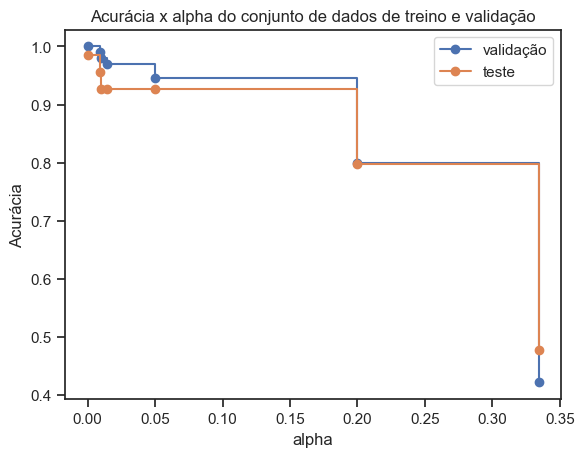

In [55]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [56]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 98.55


DecisionTreeClassifier(random_state=2360873)

### 6. Avaliando a melhor árvore<a name="6"></a>
[Voltar para o índice](#topo)

Agora é a hora da verdade, vamos ver se essa acurácia se "sustenta" na base de testes.

Acurácia: 94.20


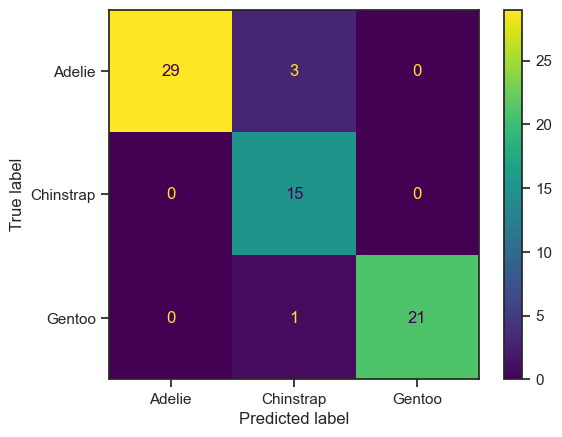

In [58]:
acuracia_teste = melhor_arvore.score(X_test, y_test)

print(f'Acurácia: {acuracia_teste*100:.2f}')
cm = confusion_matrix(y_test, melhor_arvore.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=melhor_arvore.classes_).plot()

### 7. Gancho para a próxima aula:<a name="7"></a>
[Voltar para o índice](#topo)

- O que aconteceria se tivessemos pego outra base de testes?
- Será que essa base de testes não propicia casualmente uma acurácia maior ou menor?
- Já estamos 'perdendo' 20% da base para teste, perdemos outros 20% para validação, não podemos minimizar isso?

# *Cross validation II: Gridsearch*

### Índice <a name="topo"></a>
- 1. [Introdução](#1)
- 2. [Carregando a base](#2)
- 3. [Separando a base de testes](#3)
- 4. [Obter os caminhos de poda via ccp-alpha](#4)
- 5. [*k-fold*, com *holdout*](#5)
- 6. [Modelo Final](#6)
- 7. [Conclusões](#7)
- 8. [Referências](#8)

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## 1. Introdução <a name="1"></a>
[Voltar para o índice](#topo)

O gancho da aula passada:

- O que aconteceria se tivessemos pego outra base de testes?
- Será que essa base de testes não propicia casualmente uma acurácia maior ou menor?
- Já estamos 'perdendo' 20% da base para teste, perdemos outros 20% para validação, não podemos minimizar isso?

Vamos abordar as perguntas acima com as técnicas de validação cruzada que acabamos de ver.

A estratégia é a seguinte: 
- Separar uma base de testes (também chamada de *holdout*)
- Obter os caminhos de poda com o ```ccp_alpha``` da maior árvore possível
- Encontrar a melhor poda pela estratégia *k-fold* de *cross-validation* para cada *ccp-alpha*:
    - dividir a base de treinamento em k-grupos (chamados *folds*)
    - Para cada grupo j, pertencente aos k-grupos:
        - treinar uma árvore com com o ccp-alpha da vez, utilizando todas as observações, menos as do grupo j
        - avaliar a métrica dessa árvore utilizando o grupo j como base de validação
    - Escolher a árvore com melhor métrica nas bases de validação
- Após escolher a melhor configuração do modelo, vamos rodar novamente o modelo nessa configuração com todos os dados (exceto os de teste)
- Avaliar o modelo na base de teste.

Pronto, este é o nosso modelo final.

### 2. Carregando a base<a name="2"></a>
[Voltar para o índice](#topo)

Nesta aula vamos carregar a base já tratada na aula passada, com os valores faltantes da variável ```sex``` preenchidos.

In [60]:
pg1 = pd.read_csv('data/pg1.csv')
pg1.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


### 3. Separando a base de testes<a name="3"></a>
[Voltar para o índice](#topo)

Dessa vez vamos separar somente uma base de testes (chamada de *holdout* pois é "mantida de fora" do processo).

In [61]:
X = pd.get_dummies(pg1.drop(columns=['island','species']), drop_first=True)
y = pg1.species

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)

### 4. Obter os caminhos de poda via ccp-alpha<a name="1.3"></a>
[Voltar para o índice](#topo)

Lembrando a estratégia: vamos obter os ```ccp_alpha``` com toda exteto a base de teste.

In [62]:
clf = DecisionTreeClassifier(random_state=2360873)
caminho = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [63]:
#garantindo que os ccp_alphas são únicos e positivos
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

In [64]:
ccp_alphas

array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
       0.01391639, 0.03817082, 0.19371502, 0.33744331])

## 5. *k-fold*, com *holdout*<a name="5"></a>
[Voltar para o índice](#topo)

Eu sei que você saberia rodar o *grid_search* "na mão", mas vamos usar uma função do scikitlearn que faz tudo isso pra nós, o ```GridSearchCV()```. Observe que o CV no nome significa *cross validation*. Essa funão faz exatamente o que precisamos: um *grid-search*, com uma avaliação das possibilidades com *cross validation*. Vamos entender como os parâmetros:

```
GridSearchCV(
    estimator,
    param_grid,
    scoring=None,
    cv=None
)
```
- **estimator**: aqui indicamos qual modelo vamos utilizar.
- **param_grid**: esse vai ser um dicionário, em que a chave é o nome dos hiperparâmetros e o valor vai ser uma lista com as possibilidades que queremos testar.
- **scoring**: vai ser a métrica de avaliação de performance do nosso modelo. No caso vamos usar a acurácia.
- **CV**: Este parâmetro, se especificado como um inteiro, é o *k* do *k-fold*. 

In [65]:
clf = DecisionTreeClassifier(random_state=2360873)
clf

DecisionTreeClassifier(random_state=2360873)

In [66]:
grid_parametros = {'ccp_alpha':ccp_alphas}
grid_parametros

{'ccp_alpha': array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
        0.01391639, 0.03817082, 0.19371502, 0.33744331])}

In [67]:
%%time
grid = GridSearchCV(estimator = clf, param_grid=grid_parametros,cv=15, verbose=100)
grid.fit(X_train, y_train) 

Fitting 15 folds for each of 9 candidates, totalling 135 fits
[CV 1/15; 1/9] START ccp_alpha=0.0..............................................
[CV 1/15; 1/9] END ...............ccp_alpha=0.0;, score=0.842 total time=   0.0s
[CV 2/15; 1/9] START ccp_alpha=0.0..............................................
[CV 2/15; 1/9] END ...............ccp_alpha=0.0;, score=0.789 total time=   0.0s
[CV 3/15; 1/9] START ccp_alpha=0.0..............................................
[CV 3/15; 1/9] END ...............ccp_alpha=0.0;, score=0.947 total time=   0.0s
[CV 4/15; 1/9] START ccp_alpha=0.0..............................................
[CV 4/15; 1/9] END ...............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 5/15; 1/9] START ccp_alpha=0.0..............................................
[CV 5/15; 1/9] END ...............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 6/15; 1/9] START ccp_alpha=0.0..............................................
[CV 6/15; 1/9] END ...............ccp_alpha=0.0

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=2360873),
             param_grid={'ccp_alpha': array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
       0.01391639, 0.03817082, 0.19371502, 0.33744331])},
             verbose=100)

In [68]:
grid

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=2360873),
             param_grid={'ccp_alpha': array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
       0.01391639, 0.03817082, 0.19371502, 0.33744331])},
             verbose=100)

In [69]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001288,0.000821,0.000546,0.000076,0.0,{'ccp_alpha': 0.0},0.842105,0.789474,0.947368,0.944444,...,1.0,1.0,1.0,1.0,0.944444,0.944444,0.944444,0.953411,0.060496,4
1,0.001158,0.000148,0.000602,0.000115,0.003629,{'ccp_alpha': 0.003629086962420302},0.842105,0.789474,0.947368,0.944444,...,1.0,1.0,1.0,1.0,0.944444,0.944444,0.944444,0.953411,0.060496,4
2,0.000986,0.000060,0.000495,0.000047,0.005495,{'ccp_alpha': 0.005494505494505495},0.842105,0.894737,0.947368,0.944444,...,1.0,1.0,1.0,1.0,0.944444,0.944444,0.944444,0.960429,0.045259,1
3,0.000975,0.000056,0.000485,0.000026,0.007525,{'ccp_alpha': 0.0075250836120401374},0.894737,0.894737,0.947368,0.888889,...,1.0,1.0,1.0,1.0,0.944444,0.944444,0.944444,0.960234,0.041555,2
4,0.001097,0.000470,0.000496,0.000042,0.010466,{'ccp_alpha': 0.010465724751439037},0.894737,0.894737,0.947368,0.888889,...,1.0,1.0,1.0,1.0,0.944444,0.944444,0.944444,0.960234,0.041555,2


In [70]:
grid.best_score_

0.9604288499025342

In [71]:
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001288,0.000821,0.000546,0.000076,0.0,{'ccp_alpha': 0.0},0.842105,0.789474,0.947368,0.944444,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.953411,0.060496,4
1,0.001158,0.000148,0.000602,0.000115,0.003629,{'ccp_alpha': 0.003629086962420302},0.842105,0.789474,0.947368,0.944444,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.953411,0.060496,4
2,0.000986,0.000060,0.000495,0.000047,0.005495,{'ccp_alpha': 0.005494505494505495},0.842105,0.894737,0.947368,0.944444,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.960429,0.045259,1
3,0.000975,0.000056,0.000485,0.000026,0.007525,{'ccp_alpha': 0.0075250836120401374},0.894737,0.894737,0.947368,0.888889,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.960234,0.041555,2
4,0.001097,0.000470,0.000496,0.000042,0.010466,{'ccp_alpha': 0.010465724751439037},0.894737,0.894737,0.947368,0.888889,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.960234,0.041555,2
5,0.000943,0.000014,0.000473,0.000011,0.013916,{'ccp_alpha': 0.013916392767933371},0.894737,0.947368,0.947368,0.888889,...,1.000000,0.944444,0.944444,1.000000,0.944444,0.944444,0.888889,0.952632,0.039232,6
6,0.000951,0.000039,0.000484,0.000026,0.038171,{'ccp_alpha': 0.03817082388510958},0.842105,0.894737,0.894737,0.833333,...,1.000000,0.944444,0.944444,0.944444,0.944444,0.944444,0.888889,0.930994,0.053892,7
7,0.001011,0.000126,0.000508,0.000059,0.193715,{'ccp_alpha': 0.19371501717135625},0.842105,0.894737,0.894737,0.833333,...,0.833333,0.944444,0.944444,0.777778,0.777778,0.777778,0.888889,0.853216,0.052796,8
8,0.000978,0.000059,0.000511,0.000097,0.337443,{'ccp_alpha': 0.33744330557517377},0.736842,0.789474,0.789474,0.777778,...,0.444444,0.444444,0.444444,0.777778,0.444444,0.444444,0.722222,0.572904,0.158207,9


### 6. Modelo Final<a name="6"></a>
[Voltar para o índice](#topo)

Agora vamos reajustar o modelo final com o parâmetro ```ccp_alpha``` que forneceu o melhor resultado, e calcular a sua acurácia.

In [72]:
melhor_ccp = resultados.iloc[grid.best_index_,4]

clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=melhor_ccp).fit(X_train, y_train)

In [73]:
clf.score(X_test, y_test)

0.9855072463768116

### 7. Conclusões<a name="7"></a>
[Voltar para o índice](#topo)

- O resultado final na base de testes está bem razoável, e dentro da expectativa do *cross-validation* - próximo da acurácia média, em comparação com o erro padrão.

- Essas técnicas de validação cruzada podem demandar um certo esforço computacional. Dependendo do tamanho da base e do número de variáveis pode tomar um tempo representativo e pode demandar um planejamento mais cuidadoso.

### 8. Referências<a name="8"></a>
[Voltar para o índice](#topo)

- [Documentação do scikitlearn](https://scikit-learn.org/stable/modules/cross_validation.html)

- "The Elements of Statistical Learning" J. H. Friedman, R. Tibshirani e  . Hastle (disponível [aqui](https://web.stanford.edu/~hastie/Papers/ESLII.pdf))

- "An Introduction to Statistical Learning" Gareth M. James, Daniela Witten, Trevor Hastie, R J Tibshirani (disponível [aqui](https://www.statlearning.com/))